Spark Version: 3.5.0
Cargando datos desde: /opt/spark-data/raw/secop_contratos.parquet


Registros cargados: 1,000
Columnas: 9

=== ESQUEMA DEL DATASET ===
root
 |-- referencia_del_contrato: string (nullable = true)
 |-- nit_entidad: string (nullable = true)
 |-- nombre_entidad: string (nullable = true)
 |-- departamento: string (nullable = true)
 |-- ciudad: string (nullable = true)
 |-- tipo_de_contrato: string (nullable = true)
 |-- valor_del_contrato: string (nullable = true)
 |-- fecha_de_firma: string (nullable = true)
 |-- estado_contrato: string (nullable = true)


=== PRIMERAS 10 FILAS ===
+-----------------------+-----------+--------------------+--------------------+-----------+--------------------+------------------+--------------------+---------------+
|referencia_del_contrato|nit_entidad|      nombre_entidad|        departamento|     ciudad|    tipo_de_contrato|valor_del_contrato|      fecha_de_firma|estado_contrato|
+-----------------------+-----------+--------------------+--------------------+-----------+--------------------+------------------+--------------

+-------+-----------------------+--------------------+--------------------+------------+---------+--------------------+--------------------+--------------------+---------------+
|summary|referencia_del_contrato|         nit_entidad|      nombre_entidad|departamento|   ciudad|    tipo_de_contrato|  valor_del_contrato|      fecha_de_firma|estado_contrato|
+-------+-----------------------+--------------------+--------------------+------------+---------+--------------------+--------------------+--------------------+---------------+
|  count|                   1000|                1000|                1000|        1000|     1000|                1000|                1000|                 915|           1000|
|   mean|   1.172387684904548...|    1.573778851578E9|                NULL|        NULL|     NULL|                NULL|    2.003122719135E9|                NULL|           NULL|
| stddev|    4.72849731711464E12|2.2509138027882605E9|                NULL|        NULL|     NULL|            


Dataset guardado en: /opt/spark-data/processed/secop_eda.parquet
SparkSession finalizada


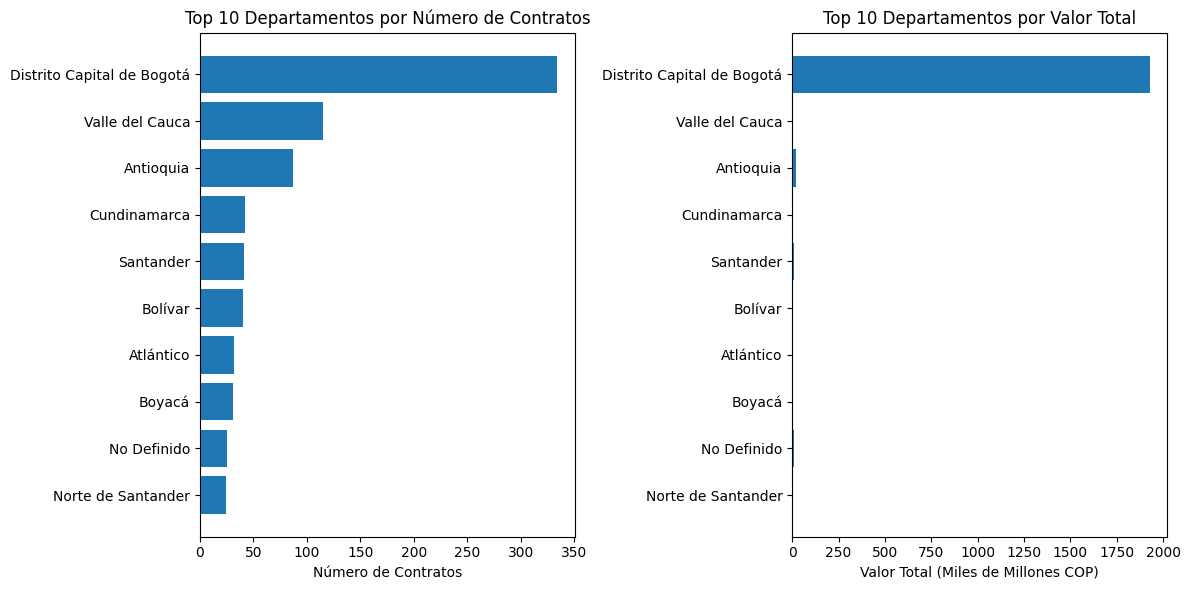

In [4]:
# %% [markdown]
# # Notebook 02: Análisis Exploratorio de Datos (EDA)
#
# **Objetivo**: Entender la distribución de las variables, identificar valores nulos y outliers.
#
# ## Actividades:
# 1. Cargar datos desde Parquet
# 2. Calcular estadísticas descriptivas
# 3. Analizar distribución por departamento
# 4. Identificar valores faltantes
# 5. Detectar outliers en valores de contratos

# %%
# Importar librerías
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, count, sum as spark_sum, avg, min as spark_min,
    max as spark_max, stddev, isnan, when, isnull, desc
)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# %%
# Configurar SparkSession
spark = SparkSession.builder \
    .appName("SECOP_EDA") \
    .master("spark://spark-master:7077") \
    .config("spark.executor.memory", "2g") \
    .getOrCreate()

print(f"Spark Version: {spark.version}")

# %%
# Cargar datos desde Parquet
parquet_path = "/opt/spark-data/raw/secop_contratos.parquet"
print(f"Cargando datos desde: {parquet_path}")

df = spark.read.parquet(parquet_path)
print(f"Registros cargados: {df.count():,}")
print(f"Columnas: {len(df.columns)}")

# %%
# Mostrar esquema
print("\n=== ESQUEMA DEL DATASET ===")
df.printSchema()

# %%
# Primeras filas
print("\n=== PRIMERAS 10 FILAS ===")
df.show(10, truncate=True)

# %%
# Estadísticas descriptivas generales
print("\n=== ESTADÍSTICAS DESCRIPTIVAS ===")
df.describe().show()

# %%
# Análisis de valores nulos por columna
print("\n=== ANÁLISIS DE VALORES NULOS ===")

# Contar nulos por cada columna
null_counts = df.select([
    count(when(isnull(c) | isnan(c), c)).alias(c)
    for c in df.columns
])

# Convertir a pandas para mejor visualización
null_df = null_counts.toPandas().T
null_df.columns = ['null_count']
null_df['null_percentage'] = (null_df['null_count'] / df.count()) * 100
null_df = null_df.sort_values('null_count', ascending=False)

print(null_df[null_df['null_count'] > 0])

# %%
# Análisis de la variable objetivo: Valor del Contrato
# Nota: Ajustar nombre de columna según dataset real

# Identificar columna de valor (puede variar)
valor_cols = [c for c in df.columns if 'valor' in c.lower() or 'precio' in c.lower()]
print(f"\n=== COLUMNAS DE VALOR ENCONTRADAS ===")
for col_name in valor_cols:
    print(f"- {col_name}")

# Usar la primera columna de valor encontrada
if valor_cols:
    valor_col = valor_cols[0]
    print(f"\nUsando columna: {valor_col}")

    # Convertir a numérico si es string
    df = df.withColumn(valor_col + "_num", col(valor_col).cast("double"))

    # Estadísticas de valor del contrato
    print(f"\n=== ESTADÍSTICAS: {valor_col} ===")
    df.select(
        spark_min(col(valor_col + "_num")).alias("Min"),
        spark_max(col(valor_col + "_num")).alias("Max"),
        avg(col(valor_col + "_num")).alias("Promedio"),
        stddev(col(valor_col + "_num")).alias("Desv_Std")
    ).show()

    # Distribución por rangos
    print(f"\n=== DISTRIBUCIÓN POR RANGOS DE VALOR ===")
    df.select(
        count(when(col(valor_col + "_num") < 10000000, True)).alias("< 10M"),
        count(when((col(valor_col + "_num") >= 10000000) & (col(valor_col + "_num") < 100000000), True)).alias("10M-100M"),
        count(when((col(valor_col + "_num") >= 100000000) & (col(valor_col + "_num") < 1000000000), True)).alias("100M-1B"),
        count(when(col(valor_col + "_num") >= 1000000000, True)).alias("> 1B")
    ).show()

# %%
# Análisis por Departamento
dept_cols = [c for c in df.columns if 'departamento' in c.lower()]
if dept_cols:
    dept_col = dept_cols[0]
    print(f"\n=== TOP 10 DEPARTAMENTOS POR NÚMERO DE CONTRATOS ===")

    df_dept = df.groupBy(dept_col) \
        .agg(
            count("*").alias("num_contratos"),
            spark_sum(col(valor_col + "_num")).alias("valor_total") if valor_cols else count("*").alias("valor_total")
        ) \
        .orderBy(desc("num_contratos")) \
        .limit(10)

    df_dept.show(truncate=False)

    # Convertir a pandas para visualización
    df_dept_pandas = df_dept.toPandas()

    # Visualización
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.barh(df_dept_pandas[dept_col], df_dept_pandas['num_contratos'])
    plt.xlabel('Número de Contratos')
    plt.title('Top 10 Departamentos por Número de Contratos')
    plt.gca().invert_yaxis()

    if valor_cols:
        plt.subplot(1, 2, 2)
        plt.barh(df_dept_pandas[dept_col], df_dept_pandas['valor_total'] / 1e9)
        plt.xlabel('Valor Total (Miles de Millones COP)')
        plt.title('Top 10 Departamentos por Valor Total')
        plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.savefig('/opt/spark-data/processed/eda_departamentos.png', dpi=150, bbox_inches='tight')
    print("\nGráfico guardado: /opt/spark-data/processed/eda_departamentos.png")

# %%
# Análisis por Tipo de Contrato
tipo_cols = [c for c in df.columns if 'tipo' in c.lower() and 'contrato' in c.lower()]
if tipo_cols:
    tipo_col = tipo_cols[0]
    print(f"\n=== DISTRIBUCIÓN POR TIPO DE CONTRATO ===")

    df_tipo = df.groupBy(tipo_col) \
        .agg(count("*").alias("num_contratos")) \
        .orderBy(desc("num_contratos")) \
        .limit(10)

    df_tipo.show(truncate=False)

# %%
# Análisis por Estado del Contrato
estado_cols = [c for c in df.columns if 'estado' in c.lower()]
if estado_cols:
    estado_col = estado_cols[0]
    print(f"\n=== DISTRIBUCIÓN POR ESTADO DE CONTRATO ===")

    df_estado = df.groupBy(estado_col) \
        .agg(count("*").alias("num_contratos")) \
        .orderBy(desc("num_contratos"))

    df_estado.show(truncate=False)

# %%
# Análisis de Top Proveedores
proveedor_cols = [c for c in df.columns if 'proveedor' in c.lower()]
if proveedor_cols:
    proveedor_col = proveedor_cols[0]
    print(f"\n=== TOP 10 PROVEEDORES ===")

    df_prov = df.groupBy(proveedor_col) \
        .agg(
            count("*").alias("num_contratos"),
            spark_sum(col(valor_col + "_num")).alias("valor_total") if valor_cols else count("*").alias("valor_total")
        ) \
        .orderBy(desc("num_contratos")) \
        .limit(10)

    df_prov.show(truncate=False)

# %%
# Detección de Outliers en Valor del Contrato
if valor_cols:
    print(f"\n=== DETECCIÓN DE OUTLIERS ===")

    # Calcular percentiles
    percentiles = df.approxQuantile(valor_col + "_num", [0.25, 0.50, 0.75, 0.95, 0.99], 0.01)

    print(f"Q1 (25%): ${percentiles[0]:,.2f}")
    print(f"Q2 (50%): ${percentiles[1]:,.2f}")
    print(f"Q3 (75%): ${percentiles[2]:,.2f}")
    print(f"P95 (95%): ${percentiles[3]:,.2f}")
    print(f"P99 (99%): ${percentiles[4]:,.2f}")

    # IQR method
    q1, q3 = percentiles[0], percentiles[2]
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    print(f"\nRango normal (IQR): ${lower_bound:,.2f} - ${upper_bound:,.2f}")

    # Contar outliers
    num_outliers = df.filter(
        (col(valor_col + "_num") < lower_bound) |
        (col(valor_col + "_num") > upper_bound)
    ).count()

    print(f"Outliers detectados: {num_outliers:,} ({(num_outliers/df.count())*100:.2f}%)")

# %%
# Análisis temporal (si hay columna de fecha)
fecha_cols = [c for c in df.columns if 'fecha' in c.lower()]
if fecha_cols:
    fecha_col = fecha_cols[0]
    print(f"\n=== ANÁLISIS TEMPORAL ===")
    print(f"Columna de fecha: {fecha_col}")

    # Convertir a fecha
    from pyspark.sql.functions import to_date, year, month

    df = df.withColumn(fecha_col + "_parsed", to_date(col(fecha_col)))
    df = df.withColumn("anio", year(col(fecha_col + "_parsed")))
    df = df.withColumn("mes", month(col(fecha_col + "_parsed")))

    # Contratos por año
    print("\n=== CONTRATOS POR AÑO ===")
    df.groupBy("anio") \
        .agg(count("*").alias("num_contratos")) \
        .orderBy("anio") \
        .show()

# %%
# Resumen final del EDA
print("\n" + "="*60)
print("RESUMEN DEL ANÁLISIS EXPLORATORIO")
print("="*60)
print(f"✓ Total de registros analizados: {df.count():,}")
print(f"✓ Columnas analizadas: {len(df.columns)}")
if valor_cols:
    total_valor = df.select(spark_sum(col(valor_col + "_num"))).collect()[0][0]
    if total_valor:
        print(f"✓ Valor total de contratos: ${total_valor:,.2f}")
print(f"✓ Análisis por departamento: Completado")
print(f"✓ Análisis de outliers: Completado")
print(f"✓ Gráficos generados: /opt/spark-data/processed/")
print("="*60)

# %%
# Guardar dataset limpio para próximos notebooks
output_path = "/opt/spark-data/processed/secop_eda.parquet"
df.write.mode("overwrite").parquet(output_path)
print(f"\nDataset guardado en: {output_path}")

# %%
# Detener SparkSession
spark.stop()
print("SparkSession finalizada")